# Name: Abby Hidalgo and Zobe Murray
# Course: CPSC 322
# Final Project 
# Date: 12/11/24

In [7]:
import importlib

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyNaiveBayesClassifier, MyRandomForestClassifier

#import analysis_code.plot_utils
#importlib.reload(analysis_code.plot_utils)
import flask_app.naive_picker
importlib.reload(flask_app.naive_picker)

import flask_app.cosmetic_app
importlib.reload(flask_app.cosmetic_app)

import tabulate
from tabulate import tabulate
import numpy as np

# Experiments with Joining Datasets

In [8]:
raw_data = MyPyTable()
raw_data2 = MyPyTable()
X = []
Y = []
raw_data = raw_data.load_from_file("california_cosmetics.csv")
raw_data2 = raw_data2.load_from_file("cosmetics_kaggle.csv")
data_joined = raw_data.perform_inner_join(raw_data2, ["BrandName"])
duplicates = data_joined.find_duplicates(["BrandName"])
data_joined.drop_rows(duplicates)
data_joined.save_to_file("cosmetics_clean.csv")
row, col = data_joined.get_shape()
print("number of rows ", row)
print("number of cols ", col)

number of rows  13
number of cols  32


Based on the lack of matching columns we decided to move away from using the cosmetics kaggle data set and instead are splitting the data set in order to test our classifiers. The size of our dataset is sufficient due to it being more than 100,000 entries that need to be sorted through.

# Splitting and Training Data

In [9]:
subset = MyPyTable().load_from_file("california_cosmetics_removed_columns.csv")
row, col = subset.get_shape()
print("number of rows ", row)
print("number of cols ", col)

number of rows  114635
number of cols  6


For this we needed to pull a subset of data from the california cosmetics data set since the processing time of the whole set took too long for the project to be efficient. In the removed columns spreadsheet we reduced the number of attributes to 6, but kept the 114,635 instances. The narrowing doen of the data helped us run it in a more efficient time.

In [10]:
subset = subset.remove_rows_with_missing_values()
row, col = subset.get_shape()
print("number of rows ", row)
print("number of cols ", col)

number of rows  114595
number of cols  6


This code block removes rows with missing values in any of these attribute fields. This slightly trims the data set. 

## Examining Initial Frequency of Drug Types

In [11]:
y = subset.get_column("ChemicalName")

In [12]:
unique_vals, counts = myutils.get_frequency(y)
print(unique_vals)
print(counts)
drugs = []
for i, val in enumerate(unique_vals):
    if counts[i] > 1000:
        drugs.append(val)

print(drugs)
index = subset.column_names.index("ChemicalName")
subset2 = MyPyTable()
subset2.column_names = subset.column_names
for inst in subset.data:
    for drug in drugs:
        if inst[index] == drug:
            subset2.data.append(inst)
y2 = subset2.get_column("ChemicalName")
chemical_indices = myutils.group_by(y2)

['1,4-Dioxane', '2,2-Bis(bromomethyl)-1,3-propanediol', '2,4-Hexadienal (89% trans, trans isomer; 11% cis, trans isomer)', '2-Propyleneacrolein', 'Acetaldehyde', 'Acetic acid, retinyl ester', 'Acetylsalicylic acid', 'Acrylamide', 'All-trans retinoic acid', 'Aloe vera, non-decolorized whole leaf extract', 'Aloe vera, whole leaf extract', 'Arsenic (inorganic arsenic compounds)', 'Arsenic (inorganic oxides)', 'Aspirin', 'Avobenzone', 'Benz[a]anthracene', 'Benzene', 'Benzo[a]pyrene', 'Benzophenone', 'Benzophenone-2', 'Benzophenone-3', 'Benzophenone-4', 'Benzyl chloride', 'Bisphenol A (BPA)', 'Butylated hydroxyanisole', 'C.I. Acid Red 114', 'Cadmium and cadmium compounds', 'Caffeic acid', 'Caffeine', 'Carbon black', 'Carbon black (airborne, unbound particles of respirable size)', 'Carbon-black extracts', 'Chromium (hexavalent compounds)', 'Coal Tar', 'Coal tar extract', 'Coal tar solution', 'Coal tars', 'Cocamide', 'Cocamide DEA', 'Cocamide MEA', 'Cocamide diethanolamine', 'Cocamide diethan

These code blocks examine the general distribution of the different drugs and their frequencies in the dataset. This then allowed us to smooth the dataset so it was not so skewed. 

In [13]:
np.random.seed(0)
chosen_indices = []
for chemical in chemical_indices:
    if len(chemical) < 2000:
        chosen_indices.append(chemical)
    else:
        indices = np.random.choice(chemical, 2000, False)
        chosen_indices.append(indices)
for chemical in chosen_indices:
    print(len(chemical))

1888
1758
1362
1918
2000
1181
2000
1548
2000


In this code block we pick the 9 chemical names with the most frequent occurences in the data set and cap the number of instances for each label to 2000 instances.

In [14]:
final_subset = MyPyTable()
final_subset.column_names = subset.column_names
for chemical in chosen_indices:
    for inst in chemical:
        final_subset.data.append(subset2.data[inst])
final_subset.save_to_file("final_subset.csv")
final_y = final_subset.get_column("ChemicalName")
for i, chem in enumerate(final_y):
    if chem == "Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.":
        final_y[i] = "Retinol/retinyl esters"
    elif chem == "Silica, crystalline (airborne particles of respirable size)":
        final_y[i] = "Silica"

In [ ]:
myutils.histogram(final_y, "Chemical", "Frequency", "Distribution of Chemicals", xticks=final_y)

This histogram shows the general distribution of chemical names with Titanium Dioxide, Silica, and Retinol/retinyl esters having the highest frequency of 2000 in the data set. This step allowed us to make sure the data we processed was not too heavily skewed before feeding it to the different classifiers.

## Training classifiers

In [ ]:
final_X = final_subset.get_col_for_pred(["CompanyName", "BrandName", "PrimaryCategory", "SubCategory"])

In [ ]:
#initializing classifiers
naive_class = MyNaiveBayesClassifier()
knn_class = MyKNeighborsClassifier()
#splitting data
split = myevaluation.stratified_kfold_split(final_X, final_y, 10, 0)
y_tests = []
y_pred_naive = []
#training the data and then predicting on test sets
for fold in split:
    X_train, X_test, y_train, y_test = myutils.get_train_test(final_X, final_y, fold)
    naive_class.fit(X_train, y_train)
    y_pred_naive.extend(naive_class.predict(X_test))
    y_tests.extend(y_test)

{'Butylated hydroxyanisole': {'att1': {"Physician's Care Alliance, LLC": [2, 1700], 'Bliss World LLC': [11, 1700], 'Elizabeth Arden, Inc.': [148, 1700], 'Coty': [33, 1700], 'NYX Los Angeles, Inc.': [1124, 1700], 'Palladio Beauty Group': [56, 1700], 'S.C. Johnson & Son, Inc.': [10, 1700], 'Benefit Cosmetics': [5, 1700], 'Kiss Products, Inc.': [24, 1700], 'John Paul Mitchell Systems': [6, 1700], 'Pacific World Cosmetics': [5, 1700], 'The Procter & Gamble Company': [3, 1700], 'Davines S.p.A.': [7, 1700], 'Chattem, Inc.': [4, 1700], 'New Avon LLC': [1, 1700], 'Orlane, Inc': [14, 1700], 'Marianna Industries': [4, 1700], 'Melaleuca, Inc.': [5, 1700], 'COLGATE-PALMOLIVE COMPANY': [1, 1700], 'Shiseido America, Inc.': [1, 1700], 'KMC EXIM CORPORATION/DASHING DIVA FRANCHISE CORP': [2, 1700], 'Johnson & Johnson Consumer Companies': [1, 1700], 'Sun Pharmaceuticals, LLC': [6, 1700], 'Energizer Personal Care, LLC': [8, 1700], 'Laboratoires DECLEOR': [2, 1700], 'CARITA INTERNATIONAL': [3, 1700], 'Nar

In [ ]:
#printing the metrics
print("================================================")
print("Naive Bayes Metrics")
print("================================================")
myutils.print_metrics(y_pred_naive, y_tests)

Naive Bayes Metrics
Accuracy: 0.61
Error Rate: 0.39
Precision: 0.86
Recall: 0.69
F1 Score: 0.77
Confusion Matrix:
                                                               Butylated hydroxyanisole    Carbon black    Cocamide diethanolamine    Mica    Retinol/retinyl esters    Retinyl palmitate    Silica, crystalline (airborne particles of respirable size)    Talc    Titanium dioxide    Total  Recognition (%)
-----------------------------------------------------------  --------------------------  --------------  -------------------------  ------  ------------------------  -------------------  -------------------------------------------------------------  ------  ------------------  -------  -----------------
Butylated hydroxyanisole                                                           1311              12                         18      37                       140                   64                                                             40      48                 218  

In [ ]:
knn_class = MyKNeighborsClassifier()
#splitting data
split = myevaluation.stratified_kfold_split(final_X, final_y, 10, 0)
y_tests = []
y_pred_knn = []
#training the data and then predicting on test sets
for fold in split:
    X_train, X_test, y_train, y_test = myutils.get_train_test(final_X, final_y, fold)
    knn_class.fit(X_train, y_train)
    y_pred_knn.extend(knn_class.predict(X_test))
    y_tests.extend(y_test)

In [ ]:
print("================================================")
print("kNN Metrics")
print("================================================")
myutils.print_metrics(y_pred_knn, y_tests)

kNN Metrics
Accuracy: 0.46
Error Rate: 0.54
Precision: 0.23
Recall: 0.63
F1 Score: 0.34
Confusion Matrix:
                                                                                                       Butylated hydroxyanisole    Carbon black    Cocamide diethanolamine    Mica    Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.    Retinyl palmitate    Silica, crystalline (airborne particles of respirable size)    Talc    Titanium dioxide    Total  Recognition (%)
---------------------------------------------------------------------------------------------------  --------------------------  --------------  -------------------------  ------  -----------------------------------------------------------------------------------------------------  -------------------  -------------------------------------------------------------  ------  ------------------  -------  -----------------
Butylated hydroxyanisole                            

In [ ]:
tree_class = MyRandomForestClassifier()
#splitting data
split = myevaluation.stratified_kfold_split(final_X, final_y, 3, 0)
y_pred_tree = []
#training the data and then predicting on test sets
X_train, X_test, y_train, y_test = myutils.get_train_test(final_X, final_y, split[0])
tree_class.fit(X_train, y_train, 20, 2, 7)
y_pred_tree = tree_class.predict(X_test)

TypeError: '<' not supported between instances of 'float' and 'str'

#### Based on the provided metrics, we can see the dataset is heavily skewed toward Titanium dioxide. Both the KNN and Naive Bayes algorithms are able to pick up on this skew and Naive Bayes has a recognition rate of 97.85% for Titanium dioxide while KNN had a recognition rate of 80.86%.

In [ ]:
#printing the classification report (bonus)
print("================================================")
print("Naive Bayes Report")
print("================================================")
print(myevaluation.classification_report(y_tests, y_pred_naive, False))
print("================================================")
print("kNN Report")
print("================================================")
print(myevaluation.classification_report(y_tests, y_pred_knn, False))

Naive Bayes Report
+-----------------------------------------------------------------------------------------------------+-------------+----------+------------+-----------+
|                                                                                                     | precision   | recall   |   f1-score |   support |
+=====================================================================================================+=============+==========+============+===========+
| Butylated hydroxyanisole                                                                            | 0.0         | 0.0      |       0    |         2 |
+-----------------------------------------------------------------------------------------------------+-------------+----------+------------+-----------+
| Chromium (hexavalent compounds)                                                                     | 0.0         | 0.0      |       0    |         1 |
+--------------------------------------------------------

## Flask App Deployment

# Data Visualization

493


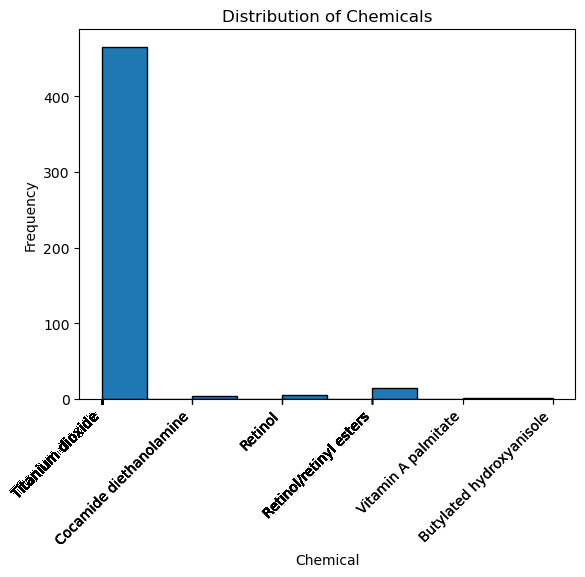

In [ ]:
for i, label in enumerate(y):
    if label == "Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.":
        y[i] = "Retinol/retinyl esters"
values, counts = myutils.get_frequency(y)
for i, val in enumerate(values):
    if counts[i] < 2:
        for inst in y:
            if inst == val:
                y.remove(inst)
print(len(y))
myutils.histogram(y, "Chemical", "Frequency", "Distribution of Chemicals", xticks=y)